# Using Velocity to Interpolate Throttle and Braking

On our first day at Thunderhill, the first order of business was to collect as much data as we possibly could to train our model. As the first couple of laps of data started to come in, we noticed that the throttle values were not being recorded. They were all zero! At this point, we were trying to have our models output the steering, throttle, and brake values, which is pretty difficult without some ground truth data to train against :) We **really** didn't want to just throw away half of our data for the day, so we decided to attempt to interpolate the throttle using the velocity vectors that were recorded.

This notebook is a walkthrough of the method we used to estimate the throttle values. Note that the provided dataset contains the actual ground-truth values for throttle and breaking so we can judge the accuracy of our method.

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cwd = os.getcwd()
data = pd.read_csv(os.path.join(cwd, 'output_example.txt'), header=0)

Looking at the first few rows in the data, we can see that each row associates an image with many snapshots of the state of the car, including the throttle, breaking, and steering. In the datasets we recorded on our first day on the track, the throttle values were all zero. 

In [4]:
data.head()

,path,heading,longitude,latitude,quarternion0,quarternion1,quarternion2,quarternion3,vel0,vel1,vel2,acc0,acc1,acc2,steering,throttle,brake
0,IMG/15395510-1490999278426810.jpeg,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,IMG/15395510-1490999278493180.jpeg,0.0,-2.135208,0.690056,-0.005517,0.015442,-0.158427,-0.987234,0.001961,0.020348,0.010102,0.0,0.0,0.0,0.043633,0.048828,0.018311
2,IMG/15395510-1490999278559608.jpeg,0.0,-2.135208,0.690056,-0.005527,0.015443,-0.158441,-0.987232,0.002141,0.021032,0.013345,0.0,0.0,0.0,0.040143,0.047302,0.018311
3,IMG/15395510-1490999278626367.jpeg,0.0,-2.135208,0.690056,-0.005593,0.015422,-0.158476,-0.987227,0.001157,0.019248,0.008533,0.0,0.0,0.0,0.041888,0.053406,0.018311
4,IMG/15395510-1490999278693029.jpeg,0.0,-2.135208,0.690056,-0.005554,0.015404,-0.158523,-0.987219,0.001074,0.019676,0.008989,0.0,0.0,0.0,0.041888,0.039673,0.018311


Let's take a peek at the ground truth data to see what our interpolated values *should* look like.

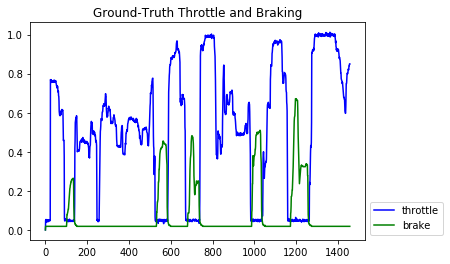

In [166]:
plt.plot(data['throttle'], 'b')
plt.plot(data['brake'], 'g')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title('Ground-Truth Throttle and Braking')

There's a little bit of noise to the data, but at first glance it looks good. When we're steping on the gas, we're not breaking and vice-versa. Just to get you in our mindset, here's what this graph would have looked like to us:

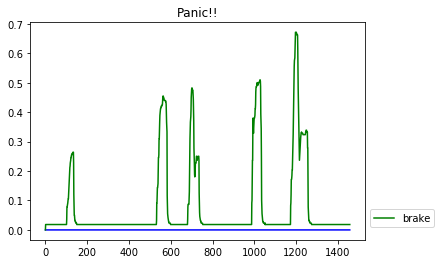

In [168]:
plt.plot(np.zeros_like(data['brake']), 'b')
plt.plot(data['brake'], 'g')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title('Panic!!')

## Interpolating the Throttle and Brake from Velocity
---

So we don't have throttle, but we do have a sequence of velocity vectors! We know that we can calculate our acceleration with two consecutive velocity vectors by **(V<sub>t+1</sub> - V<sub>t</sub>) / dt**. However, this will give us the **total** acceleration of the vehicle. This vector is perfect, IF we never turn... Turning would create a sideways velocity, potentially distorting our measurement. So what we **really** want is the magnitude of the acceleration vector **projected onto a unit length V<sub>t+1</sub>**, or just the dot-product of these vectors! This should give us a good estimate of the throttle and brake applied to the car in that timestep.

Let's do an example. If our velocities are:

V<sub>t</sub> : [0.2, 0.4]  
V<sub>t+1</sub> : [0.8, 0.6]  

Our acceleration will be (we did not have timestamps in the dataset, so we assumed **dt** to be 1 to make it easy):

A<sub>t</sub> : [0.8, 0.6] - [0.2, 0.4] = [0.6, 0.2]  

To find the scalar projection of the acceleration onto V<sub>t+1</sub>, we need to make it unit length:

||V<sub>t+1</sub>|| = (0.8<sup>2</sup> + 0.6<sup>2</sup>)<sup>0.5</sup> = 1.0 (hehehe)  
V<sub>t+1</sub> / ||V<sub>t+1</sub>|| = [0.8, 0.6] / 1.0 = [0.8, 0.6]  

Therefore, the scalar projection of the acceleration onto V<sub>t+1</sub> is:

[0.6, 0.2] &ast; [0.8, 0.6] = (0.6 &ast; 0.8) + (0.2 &ast; 0.6) = **0.6**

See the below chart for a visualization of what's happening here.

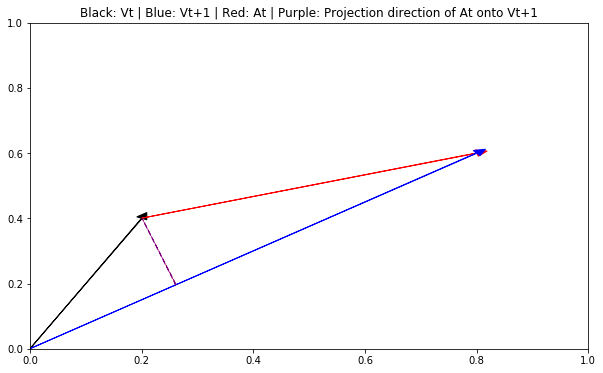

In [143]:
plt.figure(figsize=(10, 6))
plt.title('Black: Vt | Blue: Vt+1 | Red: At | Purple: Projection direction of At onto Vt+1')

plt.arrow(0.0, 0.0, 0.2, 0.4, head_width=0.02, head_length=0.02, fc='k', ec='k')
plt.arrow(0.2, 0.4, 0.6, 0.2, head_width=0.02, head_length=0.02, fc='r', ec='r')
plt.arrow(0.0, 0.0, 0.8, 0.6, head_width=0.02, head_length=0.02, fc='b', ec='b')
plt.arrow(0.2, 0.4, 0.06, -0.2, linestyle='--', fc='r', ec='purple')

Let's create a function that will apply this math to the velocities in our dataset.

In [161]:
def accel_from_velocity(velocities):
    """
    Estimates the forward/backward acceleration applied to the car from the velocity vectors.
    
    Takes in a numpy array with shape [n_obs, 2], with the first column being the X position of the velocity and the 
    second column being it's Y position. Returns a 1D numpy array with the estimated forward/backward acceleration 
    values.
    """
    n_obs = velocities.shape[0]
    
    # Calculate all of the raw accelerations at once using array slices.
    acceleration_vectors = velocities[1:] - velocities[:(n_obs-1)]
    
    # Calculate the magnitudes of the velocity vectors
    velocity_magnitudes = []
    for v1, v2 in zip(velocities[:, 0], velocities[:, 1]):
        # Make the magnitude of the velocity vector Infinity if it is close to zero.
        # This is to resolve division by zero errors, and will make the velocity vector have length
        # zero rather than one.
        if abs(v1) < 1e-5 and abs(v2) < 1e-5:
            velocity_magnitudes.append(np.inf)
        else:
            velocity_magnitudes.append(np.sqrt(v1**2 + v2**2))

    velocity_magnitudes = np.array(velocity_magnitudes)

    # Divide the original velocity vectors by their lengths to make them unit length.
    normalized_velocities = velocities[1:] / velocity_magnitudes[1:].reshape(-1, 1)

    # Get the scalar projection of the raw acceleration vectors onto the unit-length velocity vectors. 
    normalized_acceleration = np.array([normalized_velocities[k, :] @ acceleration_vectors[k, :] for k in range(n_obs-1)])
    
    # Zero out any accelerations that are too large.
    normalized_acceleration[normalized_acceleration > 1] = 0
    
    # Append a zero to the start of the array to make it the same length as the dataset. We lost an observation when
    # we differenced the velocities.
    return np.insert(normalized_acceleration, 0, [0], axis=0)


def scale_between_zero_and_one(array):
    """
    Utility function to scale an array's values between zero and one.
    """
    return (array - np.min(array)) / (np.max(array) - np.min(array))

Alright, now that we have a function that creates the estimations, let's see how it does versus the ground truth data! Some readers might notice that we are only using two of the three velocities in the dataset. The reason for this is that `vel2` is the velocity of the car in the vertical direction, which we don't really care about if we are trying to estimate the throttle and braking. Anyways, lets see how we do!

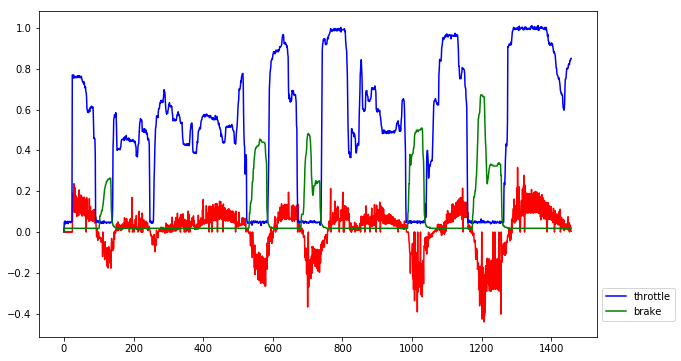

In [173]:
velocities = data[['vel0', 'vel1']].as_matrix()
projected_accelerations = accel_from_velocity(velocities)

plt.figure(figsize=(10, 6))
plt.plot(projected_accelerations, 'r')
plt.plot(data['throttle'], 'b')
plt.plot(data['brake'], 'g')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))

Not bad! Granted, the magnitude is a little off... but we can fix that! The important thing is that when the throttle is >0, our estimation is as well, and vice versa for the braking. We knew from talking with the guys at Polysync that the throttle and breaking values are between 0 and 1. So let's seperate out the negatives and the positives from our estimations into two arrays, then scale them between 0 and 1.

In [174]:
interp_throttle = np.copy(projected_accelerations)
interp_throttle[interp_throttle < 0] = 0
interp_throttle = scale_between_zero_and_one(interp_throttle)

interp_brake = np.copy(projected_accelerations)
interp_brake[interp_brake > 0] = 0
interp_brake *= -1  # Make the braking positive
interp_brake = scale_between_zero_and_one(interp_brake)

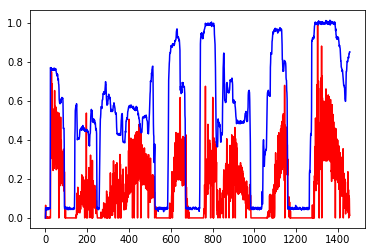

In [175]:
plt.plot(interp_throttle, 'r')
plt.plot(data['throttle'], 'b')

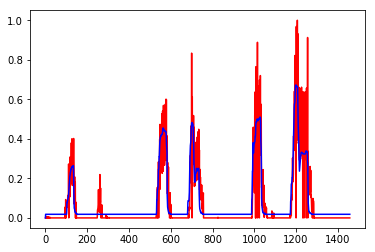

In [165]:
plt.plot(interp_brake, 'r')
plt.plot(data['brake'], 'b')

Looking at these graphs, they seem to track really well! The magnitudes could have been adjusted better, and there is a small braking spike where there shouldn't be. Other than these minor issues, our method has sucessfully estimated the throttle and braking! At the end of the day, the most important value to predict out of the control model is the steering angle :) We just needed a rough estimate of the throttle and braking to train on, and this did the job.

If you have any questions or suggestions for improvement, feel free to reach out to me at jpthalman@gmail.com.